# ***Regresion e introduccion método de Boosting***

## ***Universidad Central***

## ***Maestría en analítica de datos***

## ***Métodos estadísticos para analítica de datos.***

## ***Docente: Luis Andrés Campos Maldonado.***

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree  import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15,6)

url_base = "https://raw.githubusercontent.com/lacamposm/Metodos-Estadisticos/main/data/"

## _**[DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html)**_

### ***Predicción de una valor continuo.***

Predecir un valor continuo (también denominado regresión) con un árbol sigue la misma lógica y procedimiento que en una clasificación binaria, excepto que la impureza se mide por desviaciones al cuadrado de la media (errores cuadráticos) en cada subpartición, y el rendimiento predictivo se juzga por
la raíz cuadrada del error cuadrático medio (RMSE) en cada partición. scikit-learn tiene la clase [`sklearn.tree.DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) para entrenar un modelo de regresión del árbol de decisión.

Cuando se usan los árboles, uno de los grandes obstáculos que se enfrentan los modeladores predictivos es la naturaleza percibida de "caja negra" de los métodos que utilizan. En este sentido, el modelo de Decision Tree tiene dos
aspectos atractivos:

• Los Decision Tree proporcionan una herramienta visual para explorar los datos, para tener una idea de que variables son importantes y cómo se relacionan entre sí. Los árboles pueden capturar relaciones no lineales entre variables predictoras.

• Los Decision Tree proporcionan un conjunto de reglas que se pueden comunicar de manera efectiva a
especialistas, ya sea para la implementación o para “vender” un proyecto de analitica de datos.

Sin embargo, cuando se trata de predicción, aprovechar los resultados de múltiples árboles es típicamente más poderoso que usar un solo árbol. En particular, _Random Forrest_  casi siempre brindan una precisión predictiva superior y rendimiento, pero se pierden las mencionadas ventajas de un solo árbol.

***Ideas importantes:***


1. Los Decision Tree producen un conjunto de reglas para clasificar o predecir un resultado.

2. Las reglas corresponden a particiones sucesivas de los datos en subparticiones.

3. Cada partición, o división, hace referencia a un valor específico de una variable predictora y divide los datos en registros donde el valor del predictor está por encima o por debajo de ese valor dividido.

4. En cada etapa, el algoritmo de Decision Tree seleciona la división que minimiza el resultado de impureza dentro de cada subpartición.

5. La asiganación de la predicción se realiza siguiendo el camino que el árbol va indicando.

6. Un árbol completamente desarrollado sobreajusta (_overfitting_) los datos y debe ser podado para que capture señal y no ruido.

7. Los algoritmos como los _Random Forrest_ y árboles potenciados (_boosting_), ofrecen un mejor rendimiento predictivo, pero pierden el poder comunicativo basado en reglas de los algoritmos de Decision Tree.

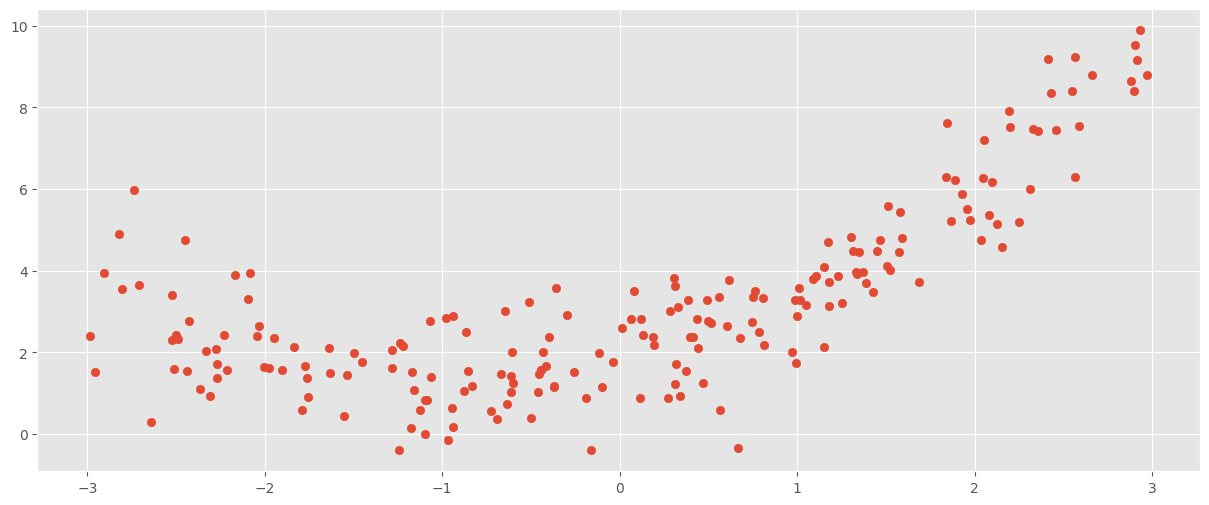

In [3]:
# Simulemos unos datos con relación cuadrática.
np.random.seed(123)
m = 200
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
df = pd.DataFrame(np.hstack((X, y)), columns=['regresor', 'y'])
plt.scatter(X,y)
plt.show()

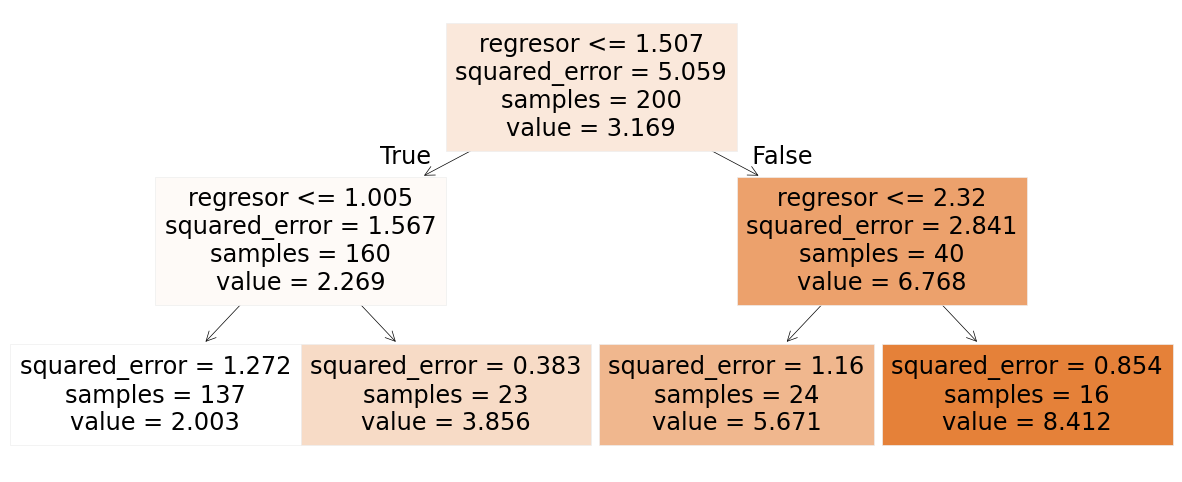

In [4]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=123)
tree_reg.fit(X, y)

plot_tree(tree_reg, filled=True, feature_names=df.drop(columns=["y"]).columns)
plt.show()

Este árbol se parece mucho al árbol de clasificación que ya conocemos. La principal diferencia es que en lugar de predecir una clase en cada nodo, predice un valor. Como ejemplo, supongamos que deseamos hacer una predicción para $x_0=2.15$, luego se debe atravezar el árbol comenzando en la raíz, y finalmente llegando al nodo hoja y el `value` que se predice es 5.671. Esta predicción es simplemente el valor objetivo promedio de la variable target en 24 registros del set de train que quedarón allí. Además esta predicción da como media del error (MSE) (`squared_error`) 1.16 sobre estos 24 registros.

El algoritmo CART funciona casi de la misma manera que antes, excepto que en lugar de tratar de dividir el set de train de una manera que minimice la impureza, ahora trata de dividir el set de train de una manera que minimice el MSE. La función de costo que el algoritmo intenta minimizar es:

$$J(k,t_k)=\frac{m_{left}}{m}MSE_{left}+\frac{m_{right}}{m}MSE_{rigth}$$

Donde:

1. $MSE_{node}=\frac{1}{m_{mode}}\displaystyle\sum_{i\in\ \ node}(\hat{y}_{node}-y^{(i)})^{2}$

2. $\hat{y}_{node}=\frac{1}{m_{node_i}}\displaystyle\sum_{i \in \ \ node}y^{(i)}$


Al igual que para las tareas de clasificación, los árboles de decisión tienden a tener `overfitting` cuando se trata con tareas de regresión. Sin ninguna regularización (es decir, utilizando el valor predeterminado hiperparámetros), es bastante probable que su algoritmo este con `overfitting`.

In [5]:
# Nodo Raiz
print("\nPara el nodo raiz:")
y_mean = df["y"].mean()
print(f"value = {y_mean:.3f}")
print(f"squared_error = {mean_squared_error(df['y'], [y_mean] * len(df)):.3f}")
print(f"Numero de muestras= {len(df)}")

# Para el primer split
print("\nPara el primer split:")
y_left = df.query("regresor <= 1.507")[["y"]]
y_right = df.query("regresor > 1.507")[["y"]]

y_left_mean = np.mean(y_left)
y_right_mean = np.mean(y_right)
m_left = len(y_left)
m_right = len(y_right)
m_total = m_left + m_right

print(f"Instancias nodo izquiero = {m_left:.3f}")
print(f"Instancias nodo derecho = {m_right:.3f}")
print(f"Instancias nodo padre = {m_total:.3f}")


mse_left = mean_squared_error(y_left, [y_left_mean] * len(y_left))
mse_right = mean_squared_error(y_right, [y_right_mean] * len(y_right))
print(f"\nMSE nodo izquierdo = {mse_left:.3f}")
print(f"MSE nodo derecho = {mse_right:.3f}")

mse_total = (m_left / m_total) * mse_left + (m_right / m_total) * mse_right

print(f"\nMSE ponderado para los nodos izquierdo y derecho: {mse_total:.3f}")


Para el nodo raiz:
value = 3.169
squared_error = 5.059
Numero de muestras= 200

Para el primer split:
Instancias nodo izquiero = 160.000
Instancias nodo derecho = 40.000
Instancias nodo padre = 200.000

MSE nodo izquierdo = 1.567
MSE nodo derecho = 2.841

MSE ponderado para los nodos izquierdo y derecho: 1.821


***Nota.***

Los árboles priorizan los límites de decisión ortogonales (todas las divisiones son perpendiculares a un eje), esto los hace sensibles a la rotación del set de train. Una forma de limitar problemas que cortes innecesarios (piense en rotar un región en 45 grados)
es usar PCA, que a menudo resulta en una mejor orientación en el set de train.

## ***Ejemplo 1.***

### ***Modelos con DecisionTreeRegressor.***

In [6]:
df_house = pd.read_csv(url_base + "kc_house_data.csv")
df_to_model = df_house.copy()
df_to_model = df_to_model.drop(columns=["id", "sqft_living15", "sqft_lot15", "date"])
df_to_model["renovated"] = df_to_model["yr_renovated"] > 0
df_to_model.drop(columns=["yr_renovated"], inplace=True)
df_to_model.info()
df_to_model

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  zipcode        21613 non-null  int64  
 14  lat            21613 non-null  float64
 15  long           21613 non-null  float64
 16  renovated      21613 non-null  bool   
dtypes: bool(1), float64(5), int64(11)
memory usage: 2.

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,renovated
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,47.5112,-122.257,False
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,47.7210,-122.319,True
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,47.7379,-122.233,False
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,47.5208,-122.393,False
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,47.6168,-122.045,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,98103,47.6993,-122.346,False
21609,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,98146,47.5107,-122.362,False
21610,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,98144,47.5944,-122.299,False
21611,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,98027,47.5345,-122.069,False


In [7]:
X = df_to_model.drop(columns=["price"])
y = df_to_model["price"]

features_categoric = ["waterfront", "zipcode", "view", "renovated", "grade"]
numerical_columns = [col for col in X.columns if col not in features_categoric]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_categoric),
        ("num", "passthrough", numerical_columns)
    ]
)

tree_model = DecisionTreeRegressor()

pipeline_tree = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", tree_model)
])

pipeline_tree.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['waterfront', 'zipcode',
                                                   'view', 'renovated',
                                                   'grade']),
                                                 ('num', 'passthrough',
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'condition',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'lat', 'long'])])),
                ('model', DecisionTreeRegressor())])

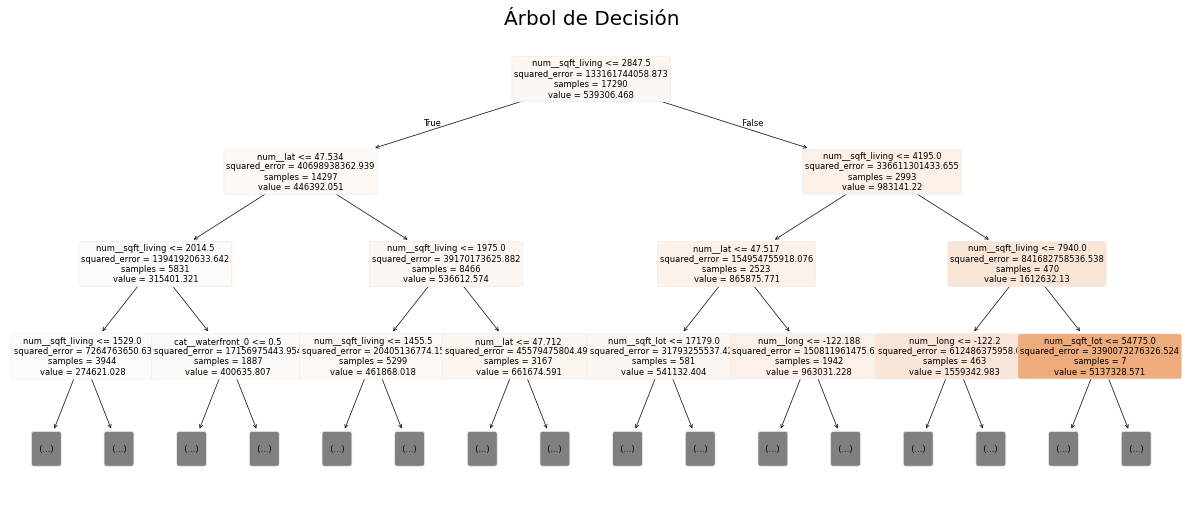

In [8]:
tree_model = pipeline_tree.named_steps["model"]

plt.figure(figsize=(15, 6))
plot_tree(
    tree_model,
    feature_names=pipeline_tree.named_steps["preprocessor"].get_feature_names_out(),
    max_depth=3,
    filled=True,
    rounded=True,
    fontsize=6
)
plt.title("Árbol de Decisión")
plt.show()

In [9]:
print("Overfitting!!!")
print(pipeline_tree.score(X_train, y_train))
print(pipeline_tree.score(X_test, y_test))

Overfitting!!!
0.9994392572882397
0.7485631468738108


In [10]:
# Buscando los "mejores" parámetros para Decision Tree
params = {
    "model__max_depth": [n + 2 for n in range(9)],
    "model__criterion": ["squared_error", "absolute_error",],
    "model__min_samples_split" : [10 + 10 * n for n in range(30)]
}

random_search_tree = RandomizedSearchCV(
    pipeline_tree,
    param_distributions=params,
    cv=5,
    n_jobs=-1,
    random_state=123,
)

search_tree = random_search_tree.fit(X_train, y_train)

print(f"'Best' params:")
pprint(search_tree.best_params_)
print(f'\nR^2 en TRAIN: {search_tree.best_estimator_.score(X_train, y_train):.4f}')
print(f'R^2 en TEST:  {search_tree.best_estimator_.score(X_test, y_test):.4f}')

'Best' params:
{'model__criterion': 'absolute_error',
 'model__max_depth': 10,
 'model__min_samples_split': 30}

R^2 en TRAIN: 0.8358
R^2 en TEST:  0.7777


### ***Modelo con RandomForestRegressor.***

In [11]:
# 2 mins corriendo
rf_model = RandomForestRegressor()

pipeline_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model)
])

pipeline_rf.fit(X_train, y_train)

# Overfitting!!!
print(pipeline_rf.score(X_train, y_train))
print(pipeline_rf.score(X_test, y_test))

0.9817950132120922
0.8921242516287557


In [12]:
# 2 min corriendo
rf_model1 = RandomForestRegressor(
    max_depth=12,
    min_samples_split=50,
    n_estimators=150    
)

pipeline_rf1 = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model1)
])

pipeline_rf1.fit(X_train, y_train)

print(pipeline_rf1.score(X_train, y_train))
print(pipeline_rf1.score(X_test, y_test))

0.8933797066346223
0.873502789478679


In [13]:
# Buscando los "mejores" parámetros para Random Forrest
base_estimator_rf = RandomForestRegressor()

pipeline_rf_best = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", base_estimator_rf)
])


params = {
    "model__max_depth": [4, 5, 6, 8, 10], 
    "model__criterion": ["squared_error", "absolute_error"],
    "model__min_samples_split": [50 + 25 * n for n in range(10)],
    "model__max_features": ["sqrt", 10, 15, 20],
    "model__n_estimators": [100 + 50 * n for n in range(5)]
}
      
search_regressor_rf = RandomizedSearchCV(
    pipeline_rf_best,
    params,
    n_iter=1,
    cv=3,
    n_jobs=-1,
    verbose=3
)

search_rf = search_regressor_rf.fit(X_train, y_train)

print("'Best' params:")
pprint(search_rf.best_params_)
print(f"\nR2 en Train: {search_rf.best_estimator_.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {search_rf.best_estimator_.score(X_test, y_test):.4f}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 2/3] END model__criterion=squared_error, model__max_depth=8, model__max_features=20, model__min_samples_split=200, model__n_estimators=100;, score=0.695 total time=   2.6s
[CV 3/3] END model__criterion=squared_error, model__max_depth=8, model__max_features=20, model__min_samples_split=200, model__n_estimators=100;, score=0.738 total time=   2.7s
[CV 1/3] END model__criterion=squared_error, model__max_depth=8, model__max_features=20, model__min_samples_split=200, model__n_estimators=100;, score=0.737 total time=   2.7s
'Best' params:
{'model__criterion': 'squared_error',
 'model__max_depth': 8,
 'model__max_features': 20,
 'model__min_samples_split': 200,
 'model__n_estimators': 100}

R2 en Train: 0.7728
R2 en Test:  0.7713


#### ***Ejercicio***

Reconstruya el mismo modelo con regresion lineal multiple, compare metricas, discuta.

In [14]:
rf_model_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    max_features=15,
    min_samples_split=50
)

rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_model_best)
])

rf_pipeline.fit(X_train, y_train)

print(f"R2 en Train: {rf_pipeline.score(X_train, y_train):.4f}")
print(f"R2 en Test:  {rf_pipeline.score(X_test, y_test):.4f}")

R2 en Train: 0.8275
R2 en Test:  0.8125


# ***Boosting. (Impulsar)***

Los modelos de ensemble son una herramienta estándar para el modelado predictivo. ***Boosting*** es un técnica general para crear un modelo de un conjunto de modelos. Como ***bagging***, ***boosting*** se usa más comúnmente con árboles de decisión. A pesar de sus similitudes, ***boosting*** toma un enfoque muy diferente. Como resultado, mientras que el ***bagging*** se puede hacer con relativamente poca afinación, ***boosting*** requiere mucho mayor cuidado en su aplicación. Si estos dos métodos fueran coches, ***bagging*** podría considerarse un Honda Accord (confiable y estable), mientras que impulsar podría ser considerado un Porsche (potente pero requiere más cuidados).

En los modelos de regresión lineal, los residuales se examinan para buscar mejorar el ajuste. ***Boosting*** toma este concepto y va mucho más allá pues se ajusta a una serie de modelos, en los que cada modelo sucesivo busca minimizar el error del modelo anterior. Varias variantes del algoritmo se usan comúnmente: ***Adaboost***, ***gradient boosting***  y ***stocastic gradient boosting***. El Boosting es un enfoque iterativo que combina múltiples modelos base (habitualmente débiles) para construir un modelo de ***ensemble*** fuerte.

## ***Algoritmo de Boosting.***


### ***Pasos del algoritmo***

1. **Inicialización**
   - Definir el número máximo de iteraciones $M$.
   - Inicializar el modelo del _ensemble_ como $\hat{F}_0(x)$, que puede ser una constante o un modelo inicial.
   - Inicializar los pesos $w_i$ para las observaciones (si aplica) o establecer las condiciones iniciales de error.

2. **Iteración**
   Para $m = 1, 2, \dots, M$:
   - **Entrenar un modelo base** $\hat{f}_m(x)$:
     - Entrenar el modelo $\hat{f}_m$ para minimizar una función objetivo específica (como error absoluto, cuadrático o log-loss).
     - Usar información previa (por ejemplo, residuales o gradientes) como insumo para ajustar el modelo $\hat{f}_m(x)$.

   - **Actualizar el modelo del _ensemble_**:
     - Combinar $\hat{f}_m(x)$ con el modelo existente $\hat{F}_{m-1}(x)$ usando un coeficiente de aprendizaje $\nu$ y un peso $\alpha_m$ (si aplica):
       $$\hat{F}_m(x) = \hat{F}_{m-1}(x) + \nu \cdot \alpha_m \cdot \hat{f}_m(x)$$

   - **Actualizar los pesos (opcional)**:
     - Ajustar los pesos $w_i$ para dar mayor importancia a las observaciones difíciles de predecir o mal clasificadas.

3. **Determinación del criterio de parada**
   - Si se alcanza $m = M$ o no hay mejora significativa en la función objetivo, detener el proceso.

4. **Predicción final**
   - El modelo de Boosting resultante es:
     $$\hat{F}(x) = \sum_{m=1}^M \alpha_m \cdot \hat{f}_m(x)$$
   - Aquí, $\alpha_m$ representa la importancia relativa de cada modelo base.


Al aumentar los pesos de las observaciones que fueron mal clasificadas, el algoritmo obliga a los modelos a entrenar más intensamente en los datos para los que se desempeñó de manera deficiente. El factor $α_m$ asegura que los modelos con menor error tengan mayor peso. El aumento de gradiente es similar a Adaboost pero presenta el problema como una optimización de una función de coste. En lugar de ajustar los pesos, el _gradient Boosting_ ajusta los modelos a un _pseudo-residual_, que tiene el efecto de entrenar más intensamente en los residuos más grandes. En el espíritu del _Random Forrest_, _stocastic gradient boosting_ agrega aleatoriedad a el algoritmo mediante el muestreo de instancias y variables predictoras en cada etapa.

#### ***Notas importantes***

- **Función objetivo**: El Boosting puede adaptarse a diferentes problemas (regresión, clasificación, ranking, etc.) modificando la función objetivo que se optimiza en cada iteración.
- **Técnicas comunes**:
  - **Gradient Boosting (GB)**: Minimiza directamente la pérdida derivada de la función objetivo, como el error cuadrático medio (para regresión) o log-loss (para clasificación).
  - **XGBoost**: Una implementación optimizada de Gradient Boosting, incluye regularización $L_1$ y $L_2$, manejo de valores faltantes, y paralelización eficiente.
  - **LightGBM** (Light Gradient Boosting Machine): Diseñada para grandes volúmenes de datos. Utiliza técnicas como histograms-based learning y _leaf-wise growth_, mejorando la velocidad y reduciendo el consumo de memoria.
  - **CatBoost**: Especialmente optimizada para datos categóricos. Usa un enfoque basado en "orden" para convertir variables categóricas en numéricas, evitando la sobreestimación del target.
  - **GBDT** (Gradient Boosted Decision Trees): Esencialmente Gradient Boosting, pero popularmente referido en el contexto de frameworks como Scikit-learn.
  - **Stochastic Gradient Boosting**: Introduce aleatoriedad en el proceso de selección de muestras o características en cada iteración, mejorando la generalización.

### ***Modelo con GradientBoosting.***

In [15]:
df_house = pd.read_csv(url_base + "kc_house_data.csv")
df_to_model = df_house.copy()
df_to_model = df_to_model.drop(columns=["id", "sqft_living15", "sqft_lot15", "date"])
df_to_model["renovated"] = df_to_model["yr_renovated"] > 0
df_to_model.drop(columns=["yr_renovated"], inplace=True)

X = df_to_model.drop(columns=["price"])
y = df_to_model["price"]

features_categoric = ["waterfront", "zipcode", "view", "renovated", "grade"]
numerical_columns = [col for col in X.columns if col not in features_categoric]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_categoric),
        ("num", "passthrough", numerical_columns)
    ]
)

gboost = GradientBoostingRegressor()

pipeline_gboost = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model_gdb", gboost)
])

pipeline_gboost.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['waterfront', 'zipcode',
                                                   'view', 'renovated',
                                                   'grade']),
                                                 ('num', 'passthrough',
                                                  ['bedrooms', 'bathrooms',
                                                   'sqft_living', 'sqft_lot',
                                                   'floors', 'condition',
                                                   'sqft_above',
                                                   'sqft_basement', 'yr_built',
                                                   'lat', 'long'])])),
                ('model_gdb', GradientBoostingRegressor())])

In [16]:
print(pipeline_gboost.score(X_train, y_train))
print(pipeline_gboost.score(X_test, y_test))

0.8926452632629666
0.8739216737915737


### ***Desglose del Algoritmo***

In [17]:
# Primeros tres arboles.
first_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[0, 0]
second_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[1, 0]
third_tree = pipeline_gboost.named_steps["model_gdb"].estimators_[2, 0]

# Predicciones acumuladas en Train
staged_predictions_train = list(pipeline_gboost.named_steps["model_gdb"].staged_predict(
    pipeline_gboost.named_steps["preprocessor"].transform(X_train)
))

In [18]:
y_mean = y_train.mean()

residuals_initial = y_train - y_mean
print("\nPrimeros 5 residuos iniciales:")
print(residuals_initial[:5])
print("\nMSE inicial = ", mean_squared_error(y_train, residuals_initial))


Primeros 5 residuos iniciales:
14305    308693.532157
19844    120643.532157
2686    -196306.467843
11926    -16806.467843
13873   -149306.467843
Name: price, dtype: float64

MSE inicial =  290851466256.9516


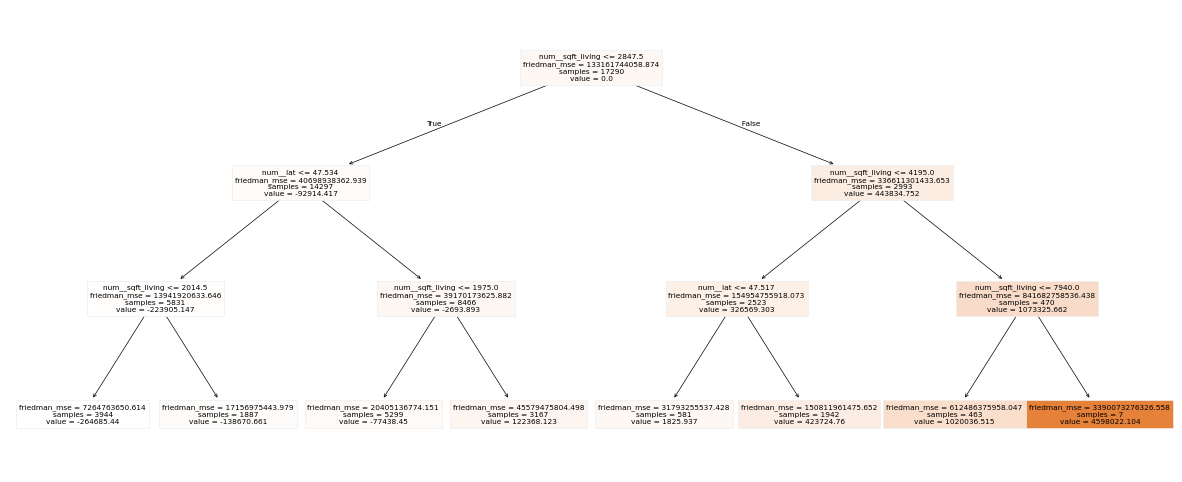

Valor de y_train:
 [848000. 659950. 343000. 522500. 390000.]
Predicciones tras el primer árbol (train):
 [551543.28013641 539489.06150592 531562.62283233 551543.28013641
 551543.28013641]
Residuos tras el primer árbol (train):
 [ 296456.71986359  120460.93849408 -188562.62283233  -29043.28013641
 -161543.28013641]

MSE primer arbol =  118104582751.37581


In [19]:
# Primer Arbol
plot_tree(first_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()

predictions_stage_1_train = staged_predictions_train[0]
residuals_stage_1_train = y_train - predictions_stage_1_train

print("Valor de y_train:\n", y_train[:5].values)
print("Predicciones tras el primer árbol (train):\n", predictions_stage_1_train[:5])
print("Residuos tras el primer árbol (train):\n", residuals_stage_1_train[:5].values)
print("\nMSE primer arbol = ", mean_squared_error(y_train, predictions_stage_1_train))

In [20]:
290851466256.9516 < 118104582751.37581

False

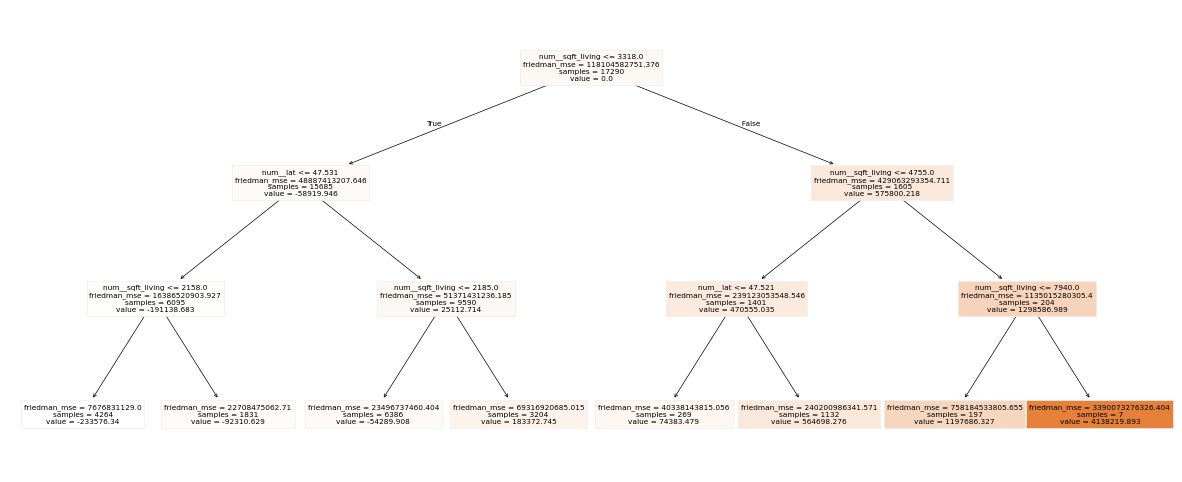

Valor de y_train:
 [848000. 659950. 343000. 522500. 390000.]
Predicciones tras el segundo árbol:
 [546114.28935615 546927.40938156 526133.63205208 569880.55461907
 569880.55461907]
Residuos tras el segundo árbol:
 [ 301885.71064385  113022.59061844 -183133.63205208  -47380.55461907
 -179880.55461907]

MSE segundo arbol =  105580164208.72095


In [21]:
# Segundo Arbol
plot_tree(second_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()

predictions_stage_2 = staged_predictions_train[1]
residuals_stage_2 = y_train - predictions_stage_2

print("Valor de y_train:\n", y_train[:5].values)
print("Predicciones tras el segundo árbol:\n", predictions_stage_2[:5])
print("Residuos tras el segundo árbol:\n", residuals_stage_2[:5].values)
print("\nMSE segundo arbol = ", mean_squared_error(y_train, predictions_stage_2))

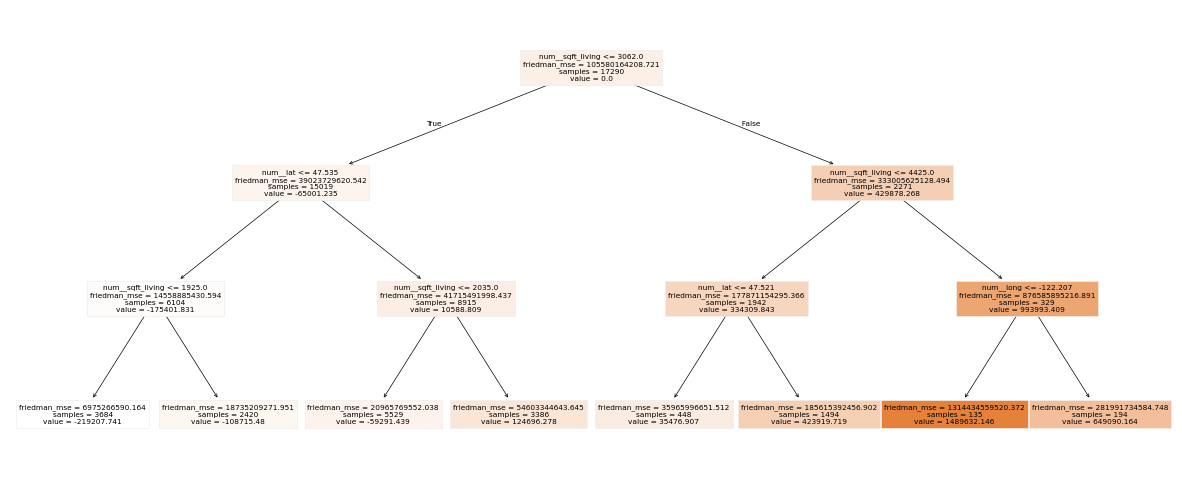

Valor de y_train:
 [848000. 659950. 343000. 522500. 390000.]
Predicciones tras el tercer árbol:
 [558583.91718657 550475.10003413 520204.48814898 582350.18244949
 582350.18244949]
Residuos tras el tercer árbol:
 [ 289416.08281343  109474.89996587 -177204.48814898  -59850.18244949
 -192350.18244949]

MSE segundo arbol =  105580164208.72095


In [22]:
# Tercer Arbol
plot_tree(third_tree, filled=True, feature_names=preprocessor.get_feature_names_out())
plt.show()
predictions_stage_3 = staged_predictions_train[2]

residuals_stage_3 = y_train - predictions_stage_3

print("Valor de y_train:\n", y_train[:5].values)
print("Predicciones tras el tercer árbol:\n", predictions_stage_3[:5])
print("Residuos tras el tercer árbol:\n", residuals_stage_3[:5].values)
print("\nMSE segundo arbol = ", mean_squared_error(y_train, predictions_stage_2))

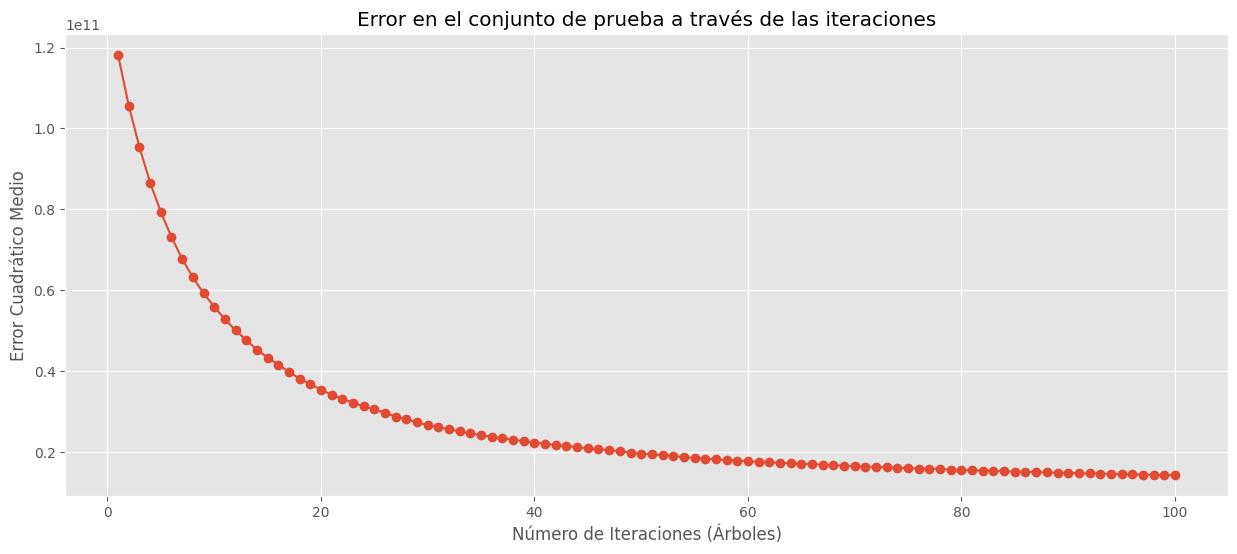

In [23]:
errors = np.zeros(100)
for i, pred in enumerate(staged_predictions_train):
    errors[i] = mean_squared_error(y_train, pred)

plt.plot(range(1, 101), errors, marker='o')
plt.title("Error en el conjunto de prueba a través de las iteraciones")
plt.xlabel("Número de Iteraciones (Árboles)")
plt.ylabel("Error Cuadrático Medio")
plt.show()